### Compositional analysis of the DMD Cardiomyocytes scRNA-Seq dataset using `milopy`
- **Developed by**: Christian Eger
- **Modified by**: Carlos Talavera-López
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 231207
- **Last modified**: 240227

## Import statements and environment prep

In [1]:
import scvi
import rpy2
import numpy as np
import scanpy as sc
import pandas as pd
import pertpy as pt
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 10.3.0
absl                NA
adjustText          1.1.1
appnope             0.1.4
arrow               1.3.0
arviz               0.18.0
asttokens           NA
attr                23.2.0
blitzgsea           NA
certifi             2024.02.02
cffi                1.16.0
chardet             5.2.0
charset_normalizer  3.3.2
chex                0.1.86
comm                0.2.2
contextlib2         NA
custom_inherit      2.4.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.1
decorator           5.1.1
decoupler           1.6.0
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.1
executing           2.0.1
flax                0.8.4
fsspec              2024.5.0
h5py                3.11.0
idna                3.7
igraph              0.11.5
importlib_resources NA
ipykernel           6.29.4
ipywidgets          8.1.3
jax                 0.4.28
jaxlib    

In [3]:
rpy2.robjects.numpy2ri.activate()

## Data preparation

### Data loading

In [4]:
adata = sc.read_h5ad("../../data/heart_mm_nuclei-23-0092_CMC_states_ctl240131.raw.h5ad")
adata.obs['cell_types'] = adata.obs['C_scANVI'].copy()
adata

AnnData object with n_obs × n_vars = 8257 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [5]:
adata
adata.obs

cell_source cell_type donor      n_counts  n_genes  \
ACACTGATCATTATCC-1-A9_2  HIRI-Nuclei       NaN  A9_2  19942.757483     3851   
TCTTCCTGTCATAACC-1-A9_2  HIRI-Nuclei       NaN  A9_2  18663.787312     3577   
ATCTCTAGTTTCAGAC-1-A9_2  HIRI-Nuclei       NaN  A9_2  19071.693405     3632   
TGAATGCAGCTCCATA-1-A9_2  HIRI-Nuclei       NaN  A9_2  19333.201556     3691   
GCAGCTGCACAAGTGG-1-A9_2  HIRI-Nuclei       NaN  A9_2  19636.587384     3778   
...                              ...       ...   ...           ...      ...   
CATGAGTAGATGGTCG-1-B2_2  HIRI-Nuclei       NaN  B2_2   5015.883804      691   
CGGTCAGCAATCGCAT-1-B2_2  HIRI-Nuclei       NaN  B2_2   4527.495736      616   
ACGTAACAGCGTGTTT-1-B2_2  HIRI-Nuclei       NaN  B2_2   4506.829197      604   
GCGTTTCTCTAGTTCT-1-B2_2  HIRI-Nuclei       NaN  B2_2   4543.968170      611   
TTGCGTCAGGACTAAT-1-B2_2  HIRI-Nuclei       NaN  B2_2   4649.395199      626   

                         percent_mito  percent_ribo region sample  \
ACACTGATCATTATCC-1-A9_2           NaN           NaN    NaN   A9_2   
TCTTCCTGTCATAACC-1-A9_2           NaN           NaN    NaN   A9_2   
ATCTCTAGTTTCAGAC-1-A9_2           NaN           NaN    NaN   A9_2   
TGAATGCAGCTCCATA-1-A9_2           NaN           NaN    NaN   A9_2   
GCAGCTGCACAAGTGG-1-A9_2           NaN           NaN    NaN   A9_2   
...                               ...           ...    ...    ...   
CATGAGTAGATGGTCG-1-B2_2           NaN           NaN    NaN   B2_2   
CGGTCAGCAATCGCAT-1-B2_2           NaN           NaN    NaN   B2_2   
ACGTAACAGCGTGTTT-1-B2_2           NaN           NaN    NaN   B2_2   
GCGTTTCTCTAGTTCT-1-B2_2           NaN           NaN    NaN   B2_2   
TTGCGTCAGGACTAAT-1-B2_2           NaN           NaN    NaN   B2_2   

                         scrublet_score  ... pct_counts_ribo percent_mt2  \
ACACTGATCATTATCC-1-A9_2             NaN  ...        0.040051    0.000267   
TCTTCCTGTCATAACC-1-A9_2             NaN  ...        0.067087    0.000268   
ATCTCTAGTTTCAGAC-1-A9_2             NaN  ...        0.060124    0.000067   
TGAATGCAGCTCCATA-1-A9_2             NaN  ...        0.127786    0.001633   
GCAGCTGCACAAGTGG-1-A9_2             NaN  ...        0.077876    0.001062   
...                                 ...  ...             ...         ...   
CATGAGTAGATGGTCG-1-B2_2             NaN  ...        2.202643    0.073128   
CGGTCAGCAATCGCAT-1-B2_2             NaN  ...        1.537071    0.111212   
ACGTAACAGCGTGTTT-1-B2_2             NaN  ...        3.258845    0.219739   
GCGTTTCTCTAGTTCT-1-B2_2             NaN  ...        5.243446    0.131086   
TTGCGTCAGGACTAAT-1-B2_2             NaN  ...        3.454894    0.180422   

                        percent_chrY XIST-counts   S_score  G2M_score  \
ACACTGATCATTATCC-1-A9_2     0.046726         0.0 -0.218301  -0.450239   
TCTTCCTGTCATAACC-1-A9_2     0.080504         0.0  0.084806  -0.395886   
ATCTCTAGTTTCAGAC-1-A9_2     0.053444         0.0 -0.352962  -0.206640   
TGAATGCAGCTCCATA-1-A9_2     0.078092         1.0 -0.159373  -0.494394   
GCAGCTGCACAAGTGG-1-A9_2     0.028319         0.0  0.351369  -0.141495   
...                              ...         ...       ...        ...   
CATGAGTAGATGGTCG-1-B2_2     0.088106         0.0  0.470334   0.083699   
CGGTCAGCAATCGCAT-1-B2_2     0.632911         0.0  0.266868  -0.118650   
ACGTAACAGCGTGTTT-1-B2_2     0.000000         0.0 -0.067282  -0.111107   
GCGTTTCTCTAGTTCT-1-B2_2     0.000000         0.0  0.119838   0.054368   
TTGCGTCAGGACTAAT-1-B2_2     0.000000         0.0 -0.100962  -0.007387   

                         _scvi_batch  _scvi_labels  C_scANVI  cell_types  
ACACTGATCATTATCC-1-A9_2            0             2      vCM2        vCM2  
TCTTCCTGTCATAACC-1-A9_2            0             2      vCM2        vCM2  
ATCTCTAGTTTCAGAC-1-A9_2            0             2      vCM2        vCM2  
TGAATGCAGCTCCATA-1-A9_2            0             2      vCM2        vCM2  
GCAGCTGCACAAGTGG-1-A9_2            0             2      vCM2        vCM2  
...    

In [6]:
sc.pp.neighbors(adata, n_neighbors=150, use_rep="X_scANVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [7]:
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 8257 × 32285
  2 modalities
    rna:	8257 x 32285
      obs:	'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'neighbors'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      obsp:	'distances', 'connectivities'
    milo:	0 x 0

In [8]:
milo.make_nhoods(mdata, prop=0.1)

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.5733082 1.6122688 1.666014  1.9378    1.3471813 1.9061624 2.2564209
 1.4248769 1.5670749 1.5817705 1.3254814 1.8550878 2.215526  1.4884009
 2.42474   2.6187227 3.098952  2.6282313 2.8623333 2.8286152 3.1912944
 2.7131295 4.208329  2.6396923 3.1372445 2.8300164 2.712457  2.8641965
 2.1129534 2.7727175 2.4676328 3.6090417 3.138709  1.5528196 1.5026413
 1.3478556 1.9259273 1.5288329 1.6461298 1.2027036 1.9774126 1.9692961
 5.694435  1.4352604 1.3662888 2.5281303 4.0280724 2.4168115 2.210379
 2.409228  2.7918904 2.0645673 2.0340009 2.110814  2.0613565 2.196866
 2.1454895 1.9871736 2.0168412 2.0696473 2.264011  2.2355814 2.0875735
 2.552351  2.1413574 2.2240121 2.3126771 2.0461078 2.1888318 2.5363982
 2.906853  1.9568962 3.460508  2.4818556 2.1840248 2.1256104 2.33285

## Defining of Neighbourhoods

In [9]:
adata.obsm["nhoods"]

<8257x697 sparse matrix of type '<class 'numpy.float32'>'
	with 147322 stored elements in Compressed Sparse Row format>

Text(0, 0.5, '# neighbouthoods')

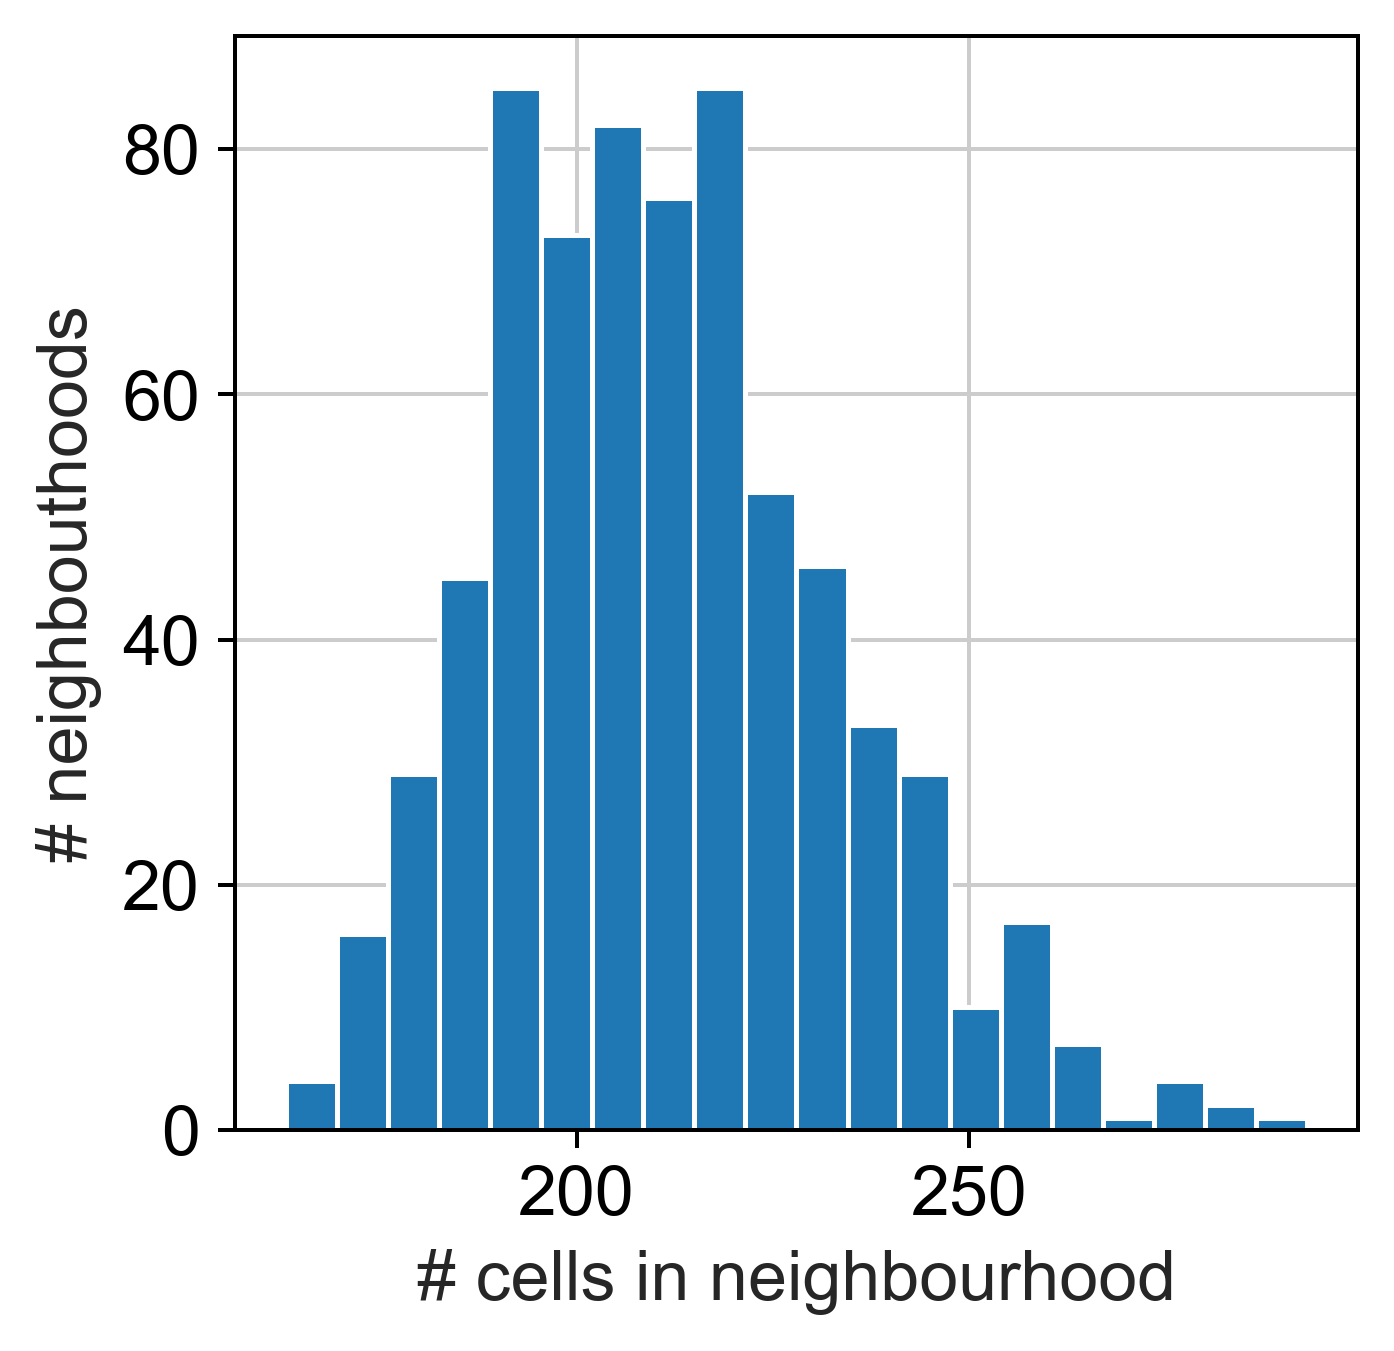

In [10]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [11]:
np.median(nhood_size)

210.0

In [12]:
sc.pp.neighbors(adata, n_neighbors=150, use_rep="X_scANVI", key_added="milo")
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.1)

computing neighbors
    finished: added to `.uns['milo']`
    `.obsp['milo_distances']`, distances for each pair of neighbors
    `.obsp['milo_connectivities']`, weighted adjacency matrix (0:00:05)


/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.5733082 1.6122688 1.666014  1.9378    1.3471813 1.9061624 2.2564209
 1.4248769 1.5670749 1.5817705 1.3254814 1.8550878 2.215526  1.4884009
 2.42474   2.6187227 3.098952  2.6282313 2.8623333 2.8286152 3.1912944
 2.7131295 4.208329  2.6396923 3.1372445 2.8300164 2.712457  2.8641965
 2.1129534 2.7727175 2.4676328 3.6090417 3.138709  1.5528196 1.5026413
 1.3478556 1.9259273 1.5288329 1.6461298 1.2027036 1.9774126 1.9692961
 5.694435  1.4352604 1.3662888 2.5281303 4.0280724 2.4168115 2.210379
 2.409228  2.7918904 2.0645673 2.0340009 2.110814  2.0613565 2.196866
 2.1454895 1.9871736 2.0168412 2.0696473 2.264011  2.2355814 2.0875735
 2.552351  2.1413574 2.2240121 2.3126771 2.0461078 2.1888318 2.5363982
 2.906853  1.9568962 3.460508  2.4818556 2.1840248 2.1256104 2.33285

Text(0, 0.5, '# neighbouthoods')

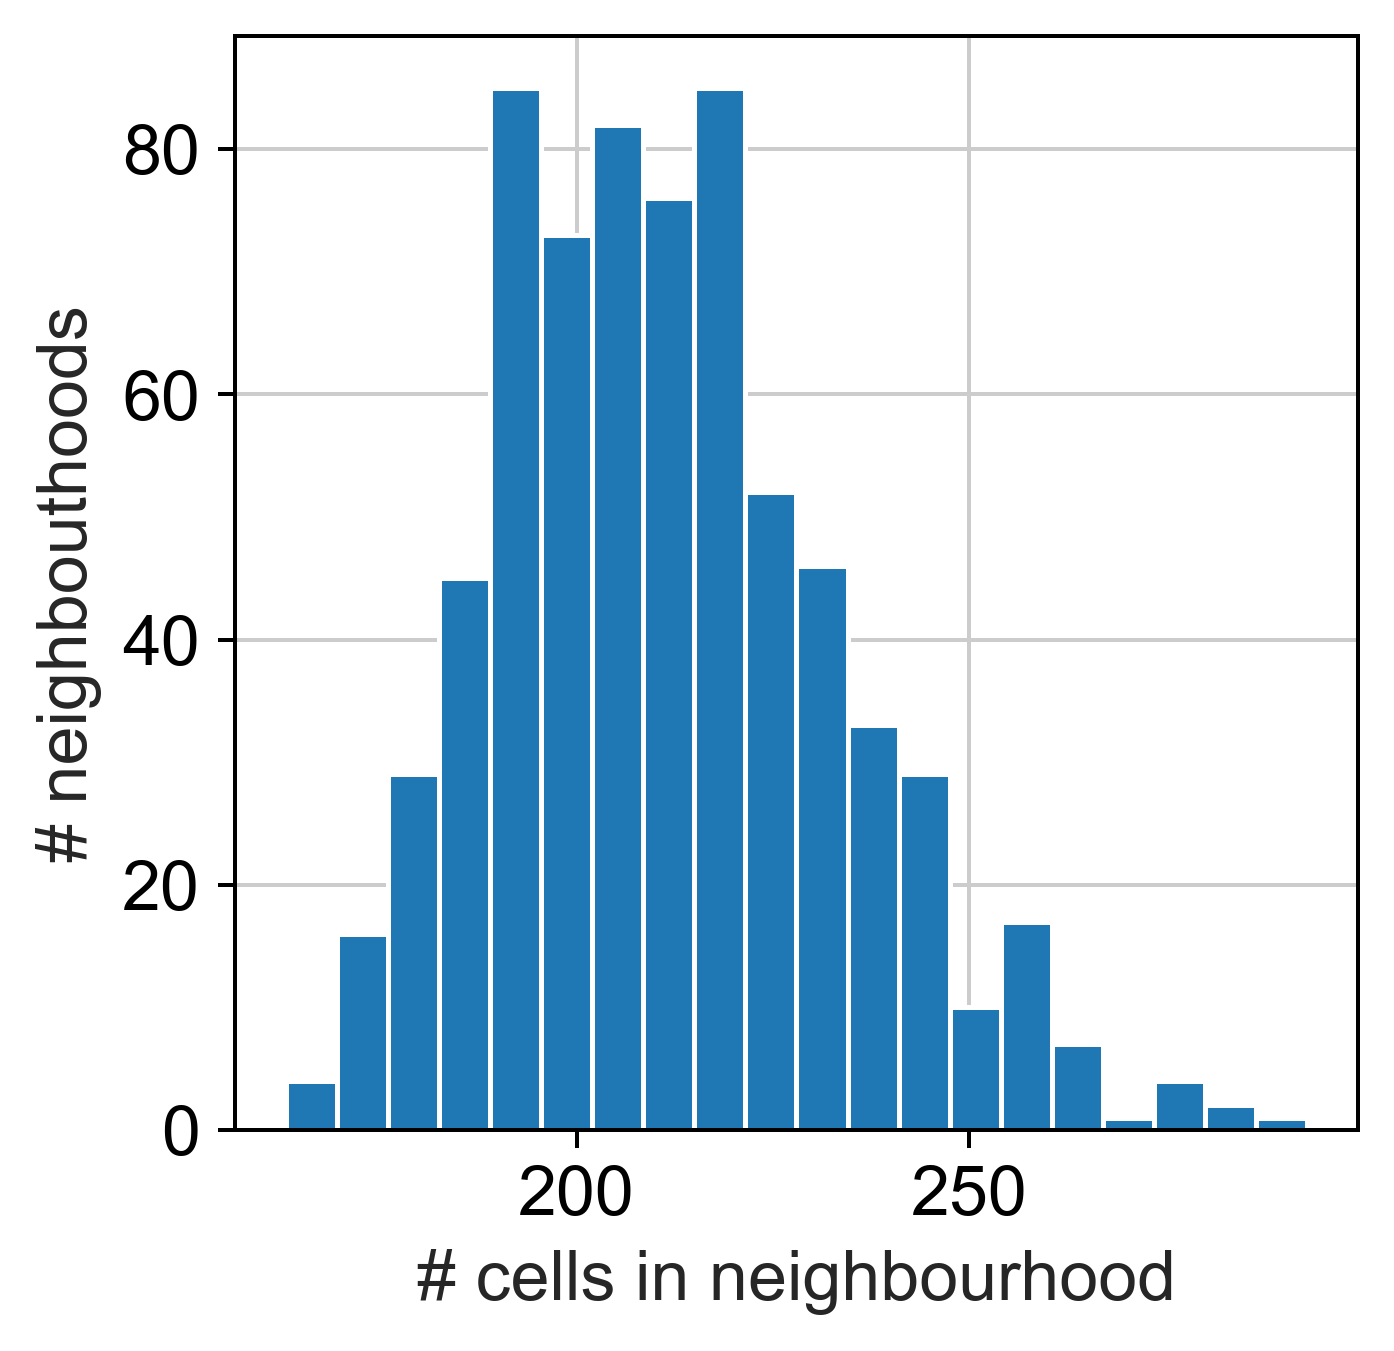

In [13]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [14]:
np.median(nhood_size)

210.0

In [15]:
milo.count_nhoods(mdata, sample_col="sample")

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 8257 × 32285
  2 modalities
    rna:	8257 x 32285
      obs:	'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'neighbors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', 'nhoods'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	6 x 697
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

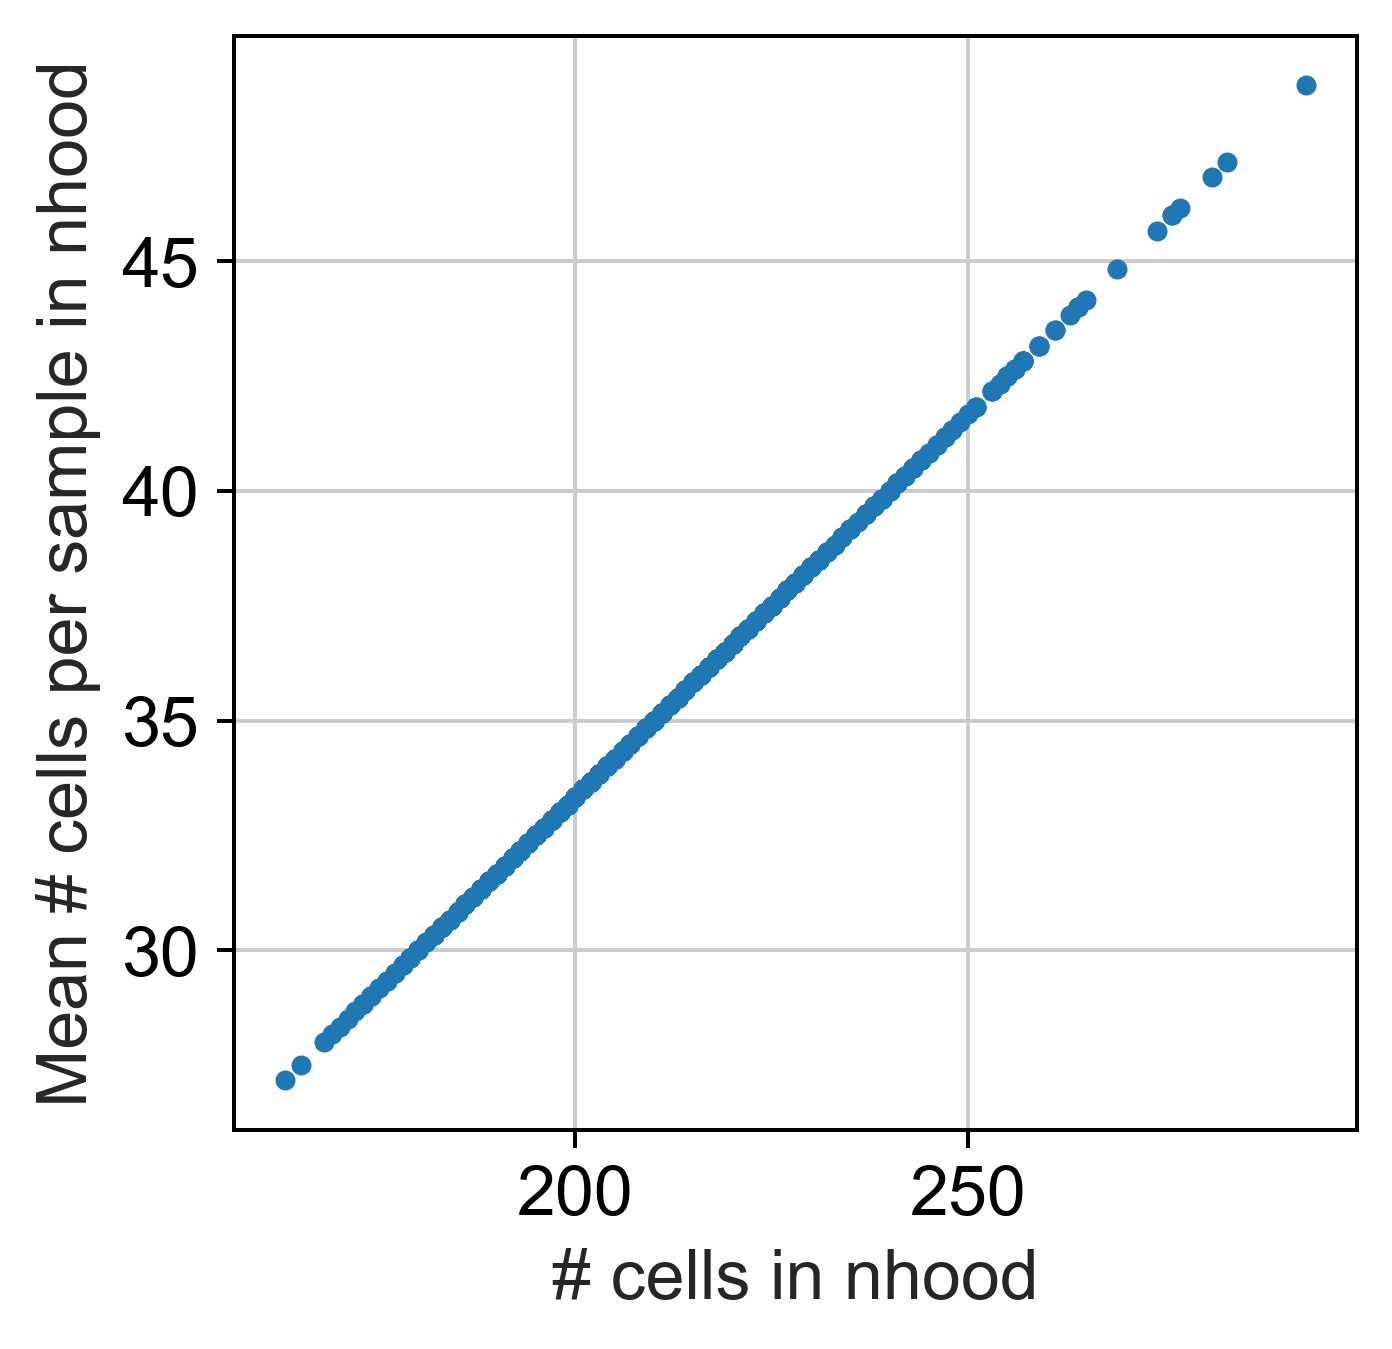

In [16]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [17]:
mdata["rna"].obs["genotype"].cat.categories

Index(['Mdx', 'MdxSCID', 'WT'], dtype='object')

In [18]:
milo.da_nhoods(
    mdata, design="~genotype", model_contrasts="genotypeWT-genotypeMdx"
)
#milo_results_healthy_iav = mdata["milo"].obs.copy()
#milo_results_healthy_iav

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:691: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:692: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


## Data Diagnostics

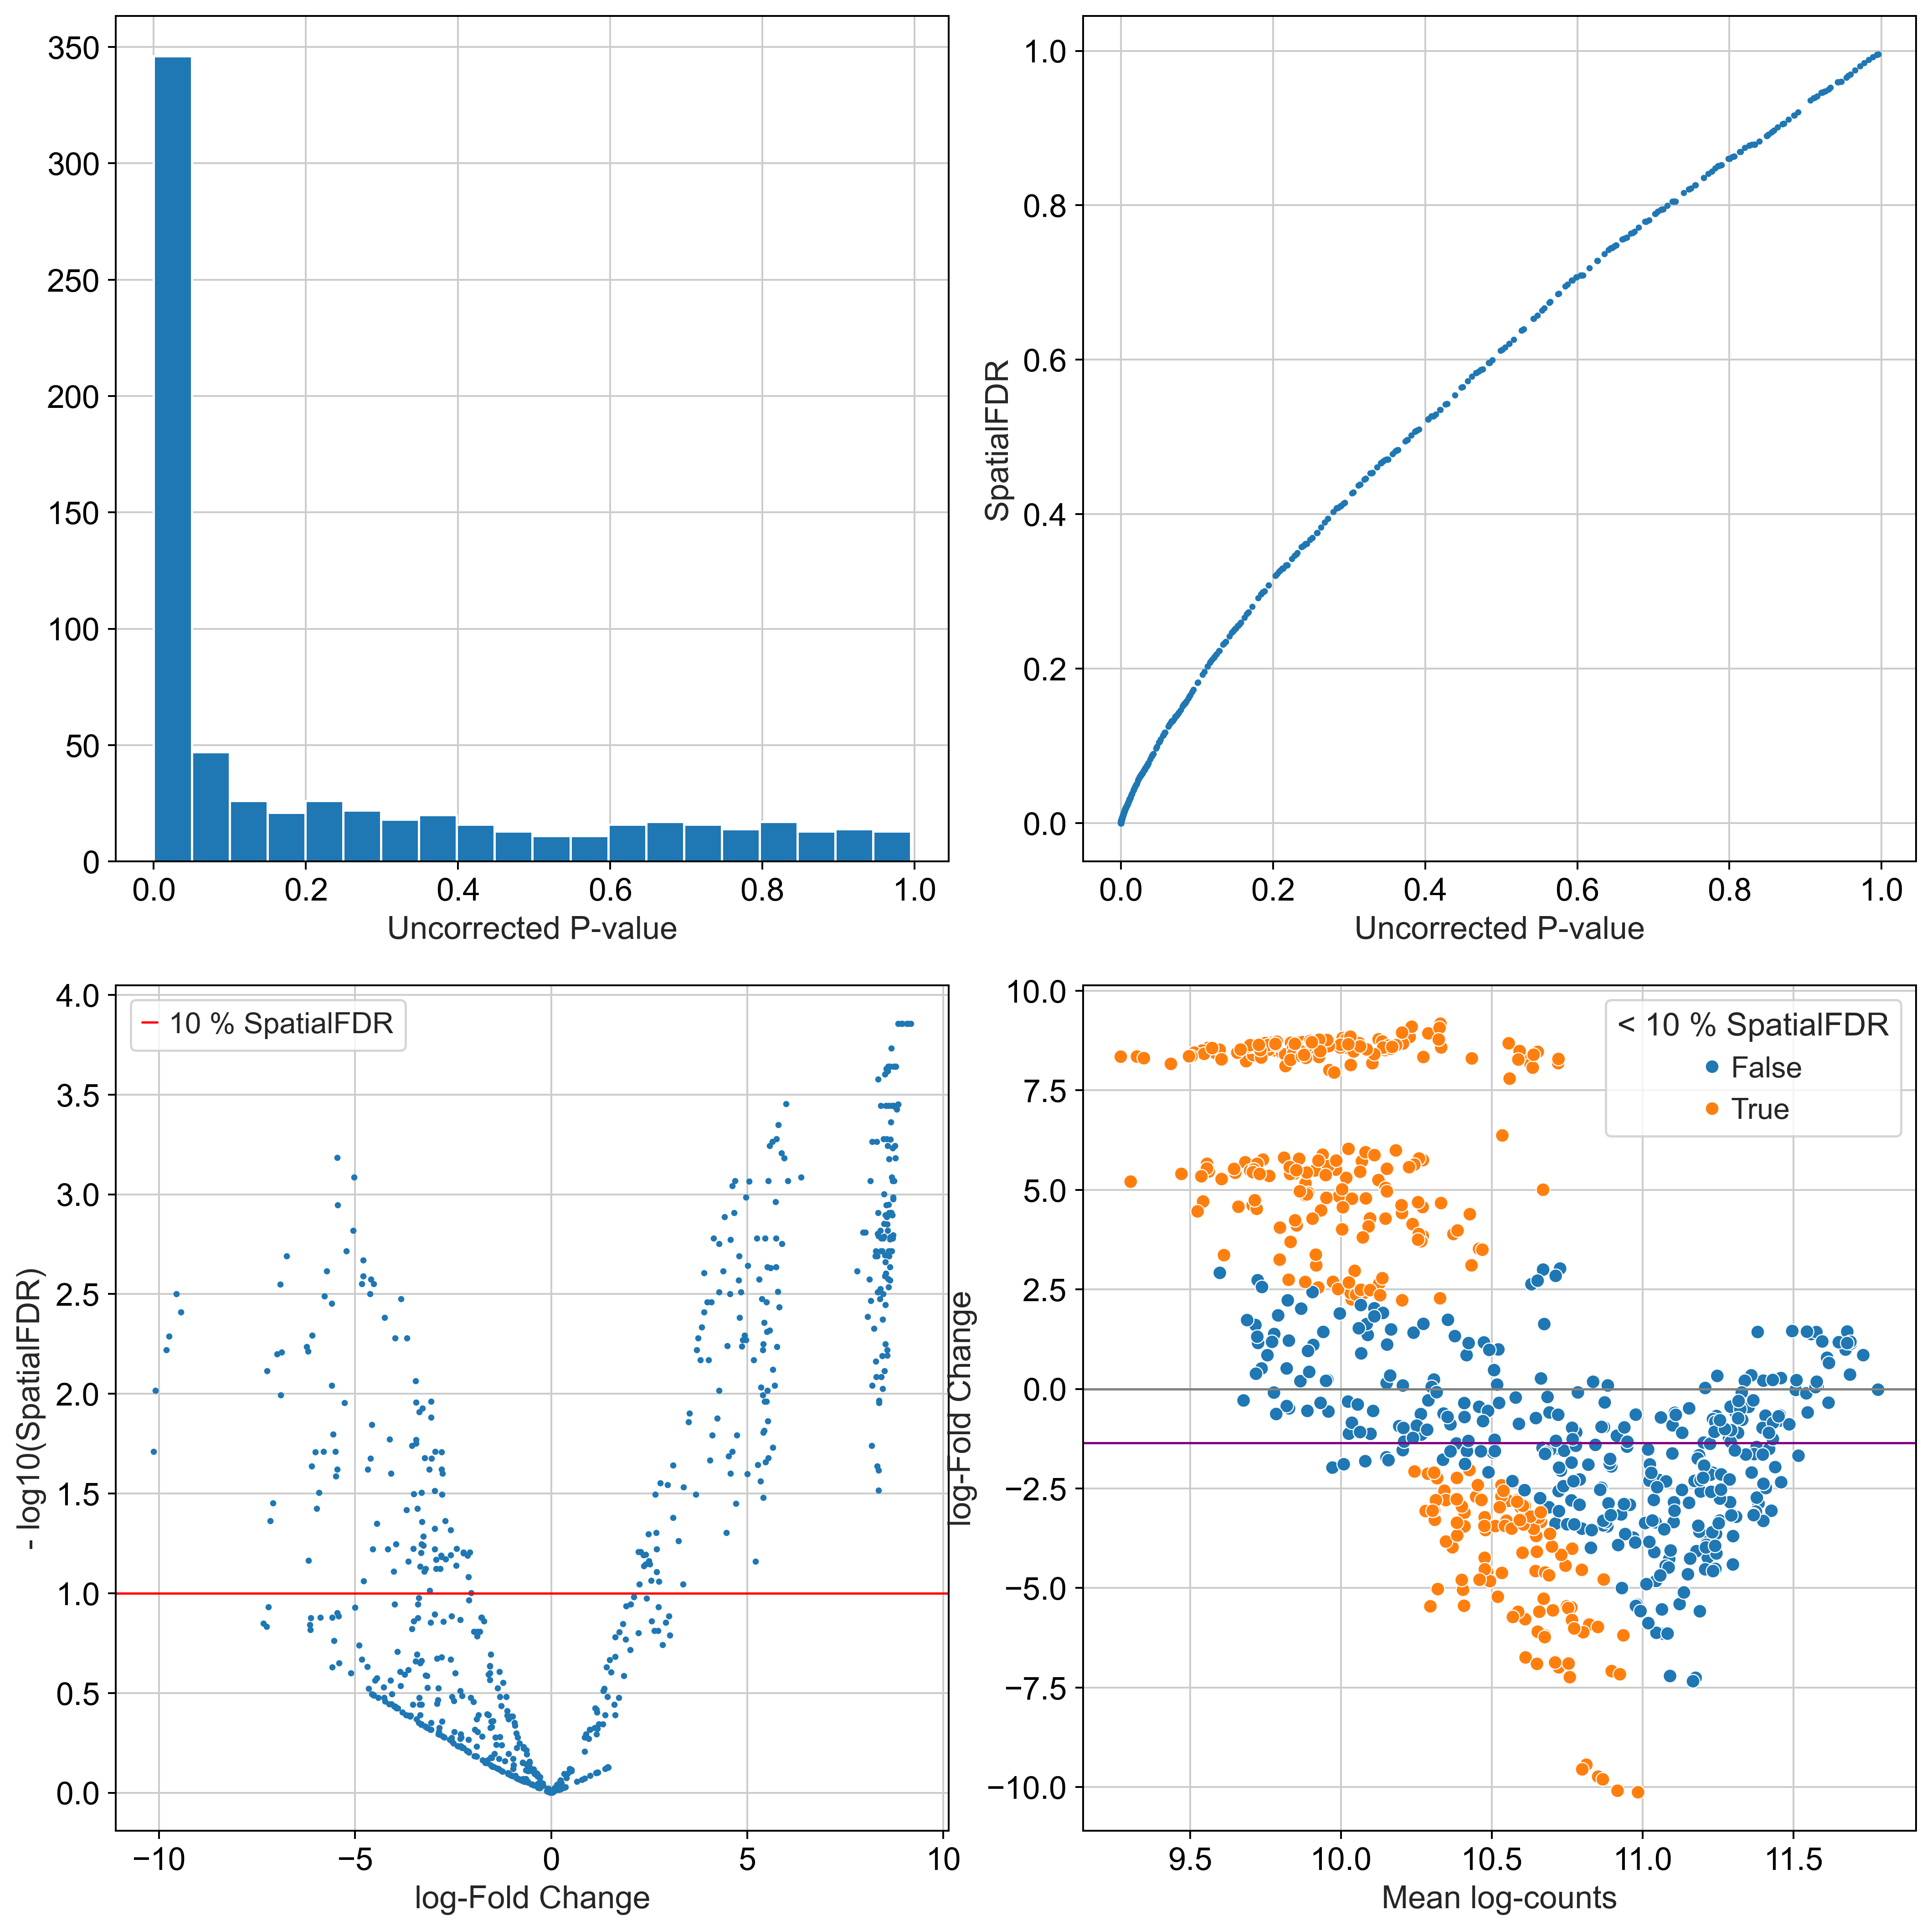

In [19]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with plt.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

## Plotting of log fold change in cell compartments

In [20]:
mdata

MuData object with n_obs × n_vars = 8257 × 32285
  2 modalities
    rna:	8257 x 32285
      obs:	'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'neighbors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', 'nhoods'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	6 x 697
      obs:	'genotype', 'sample'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig'
      uns:	'sample_col'

In [21]:
milo.build_nhood_graph(mdata)

In [22]:
mdata_milo = mdata.copy()
mdata_milo

MuData object with n_obs × n_vars = 8263 × 32982
  2 modalities
    rna:	8257 x 32285
      obs:	'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'neighbors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', 'nhoods'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	6 x 697
      obs:	'genotype', 'sample'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig', 'Nhood_size'
      uns:	'sample_col', 'nhood'
      varm:	'X_milo_graph'
      varp:	'nhood_connectivities'

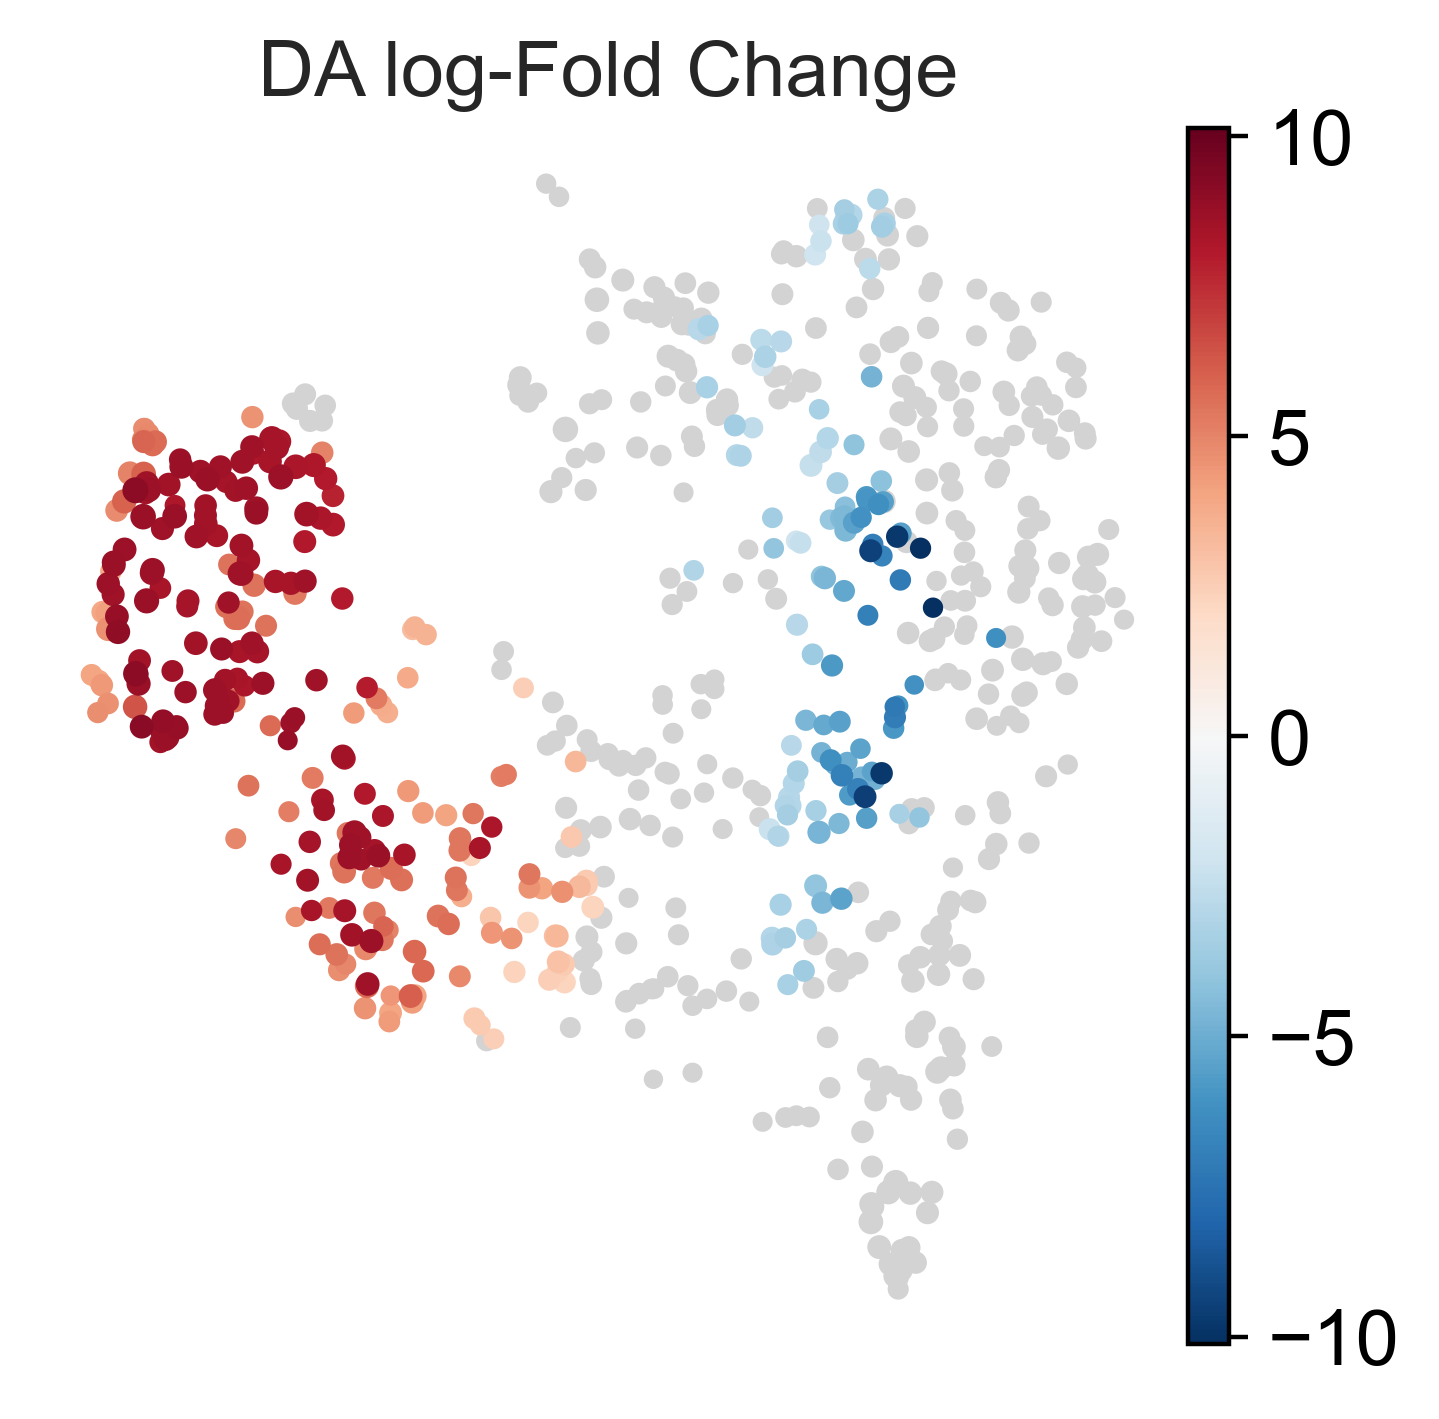

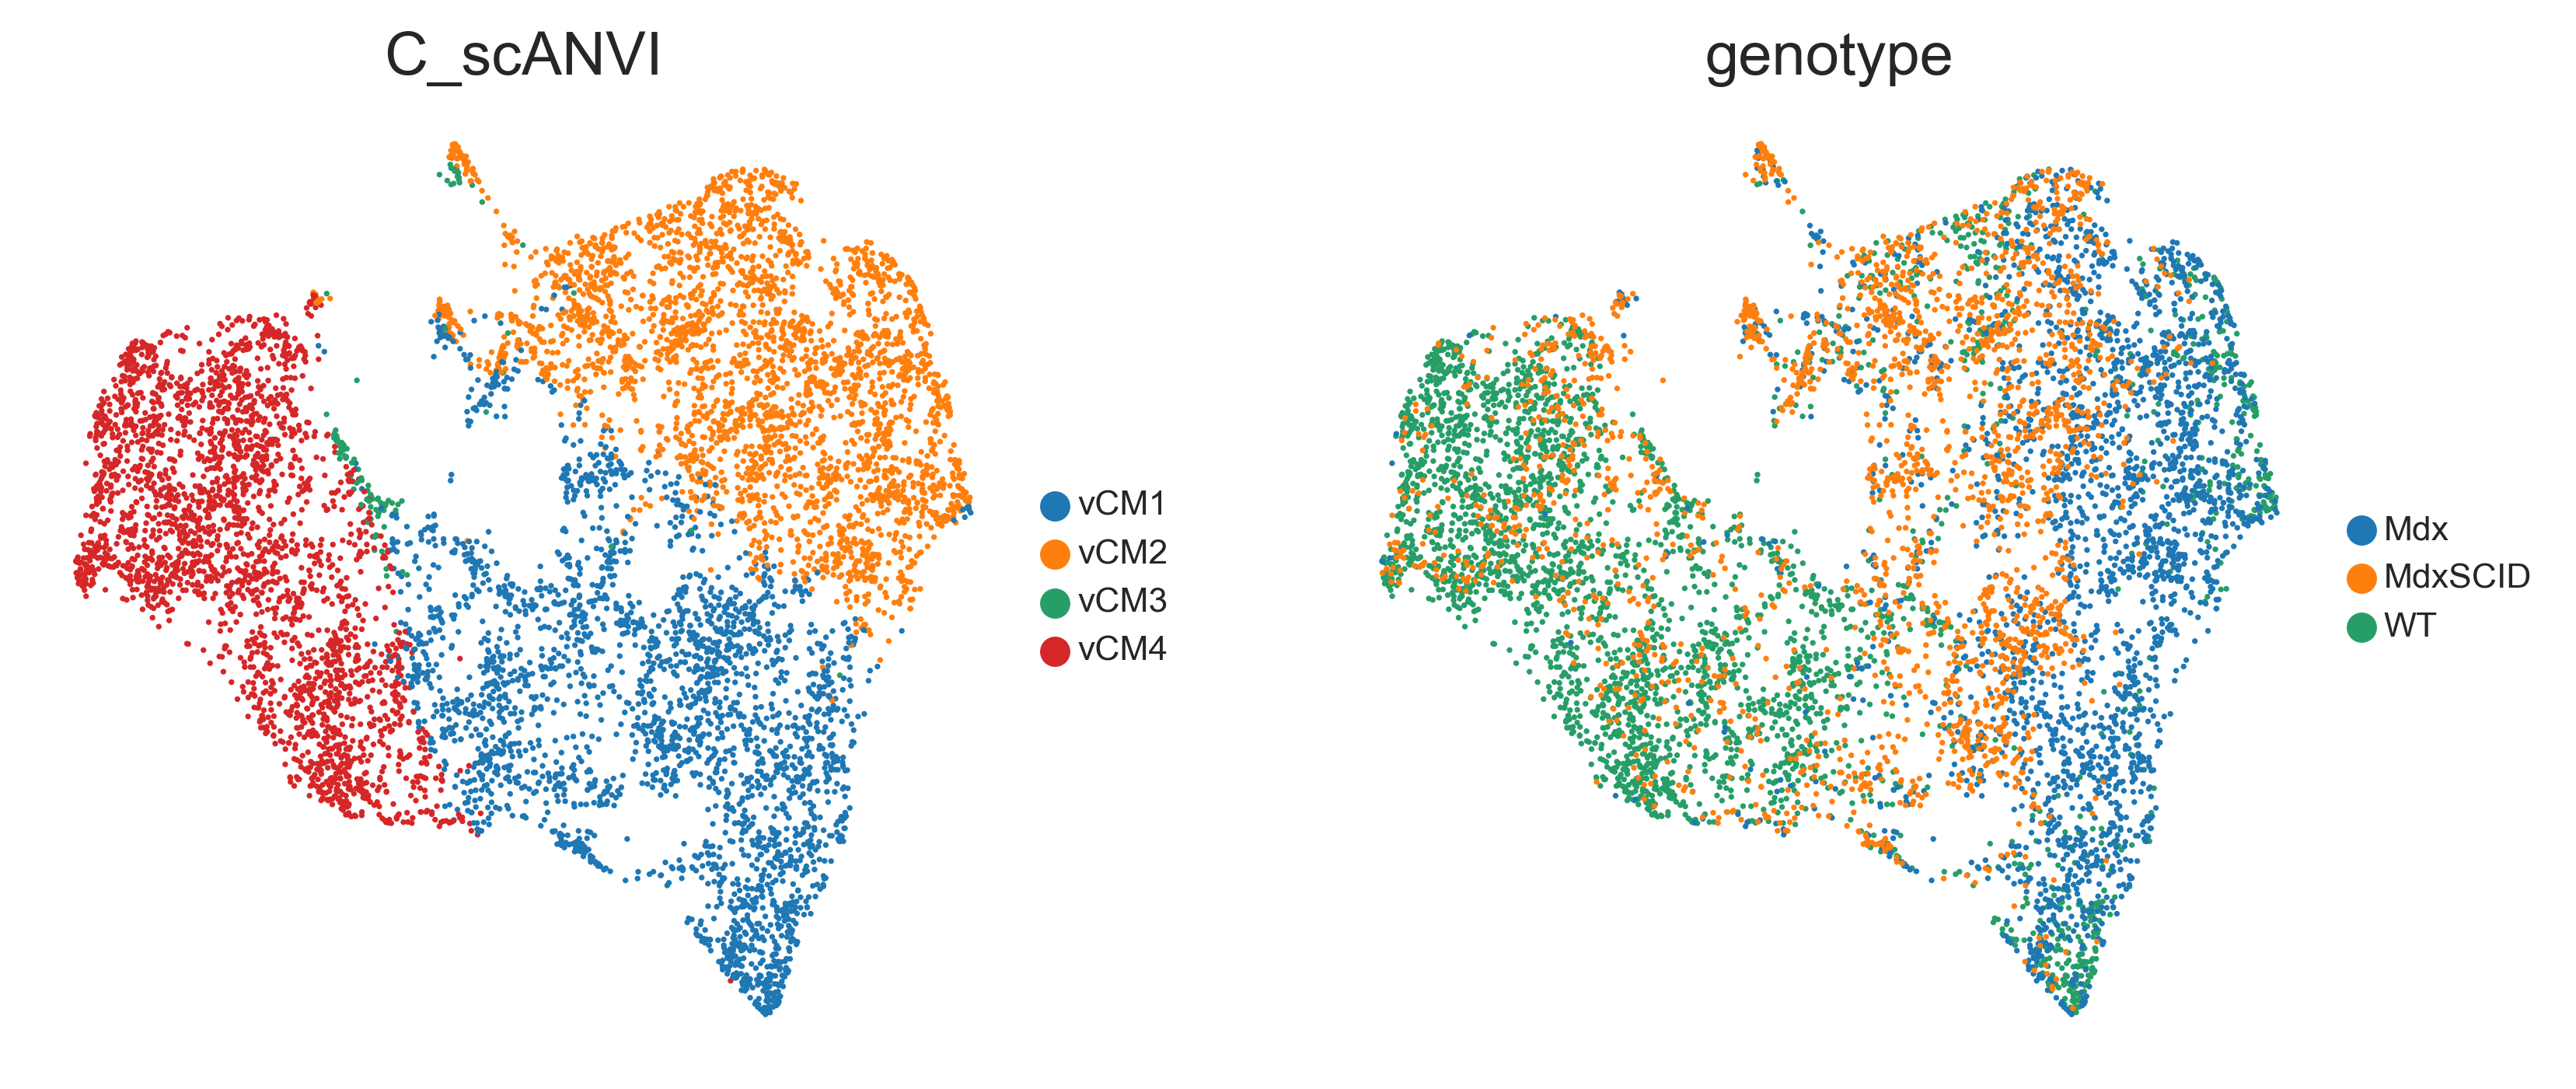

In [23]:
sc.settings.set_figure_params(dpi=200)
milo.build_nhood_graph(mdata)
with plt.rc_context({"figure.figsize": [4, 4]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.3, plot_edges=False)
    sc.pl.umap(mdata["rna"], color=["C_scANVI", "genotype"], ncols= 2, legend_loc="right margin", legend_fontsize=8 , frameon= False, size = 7)

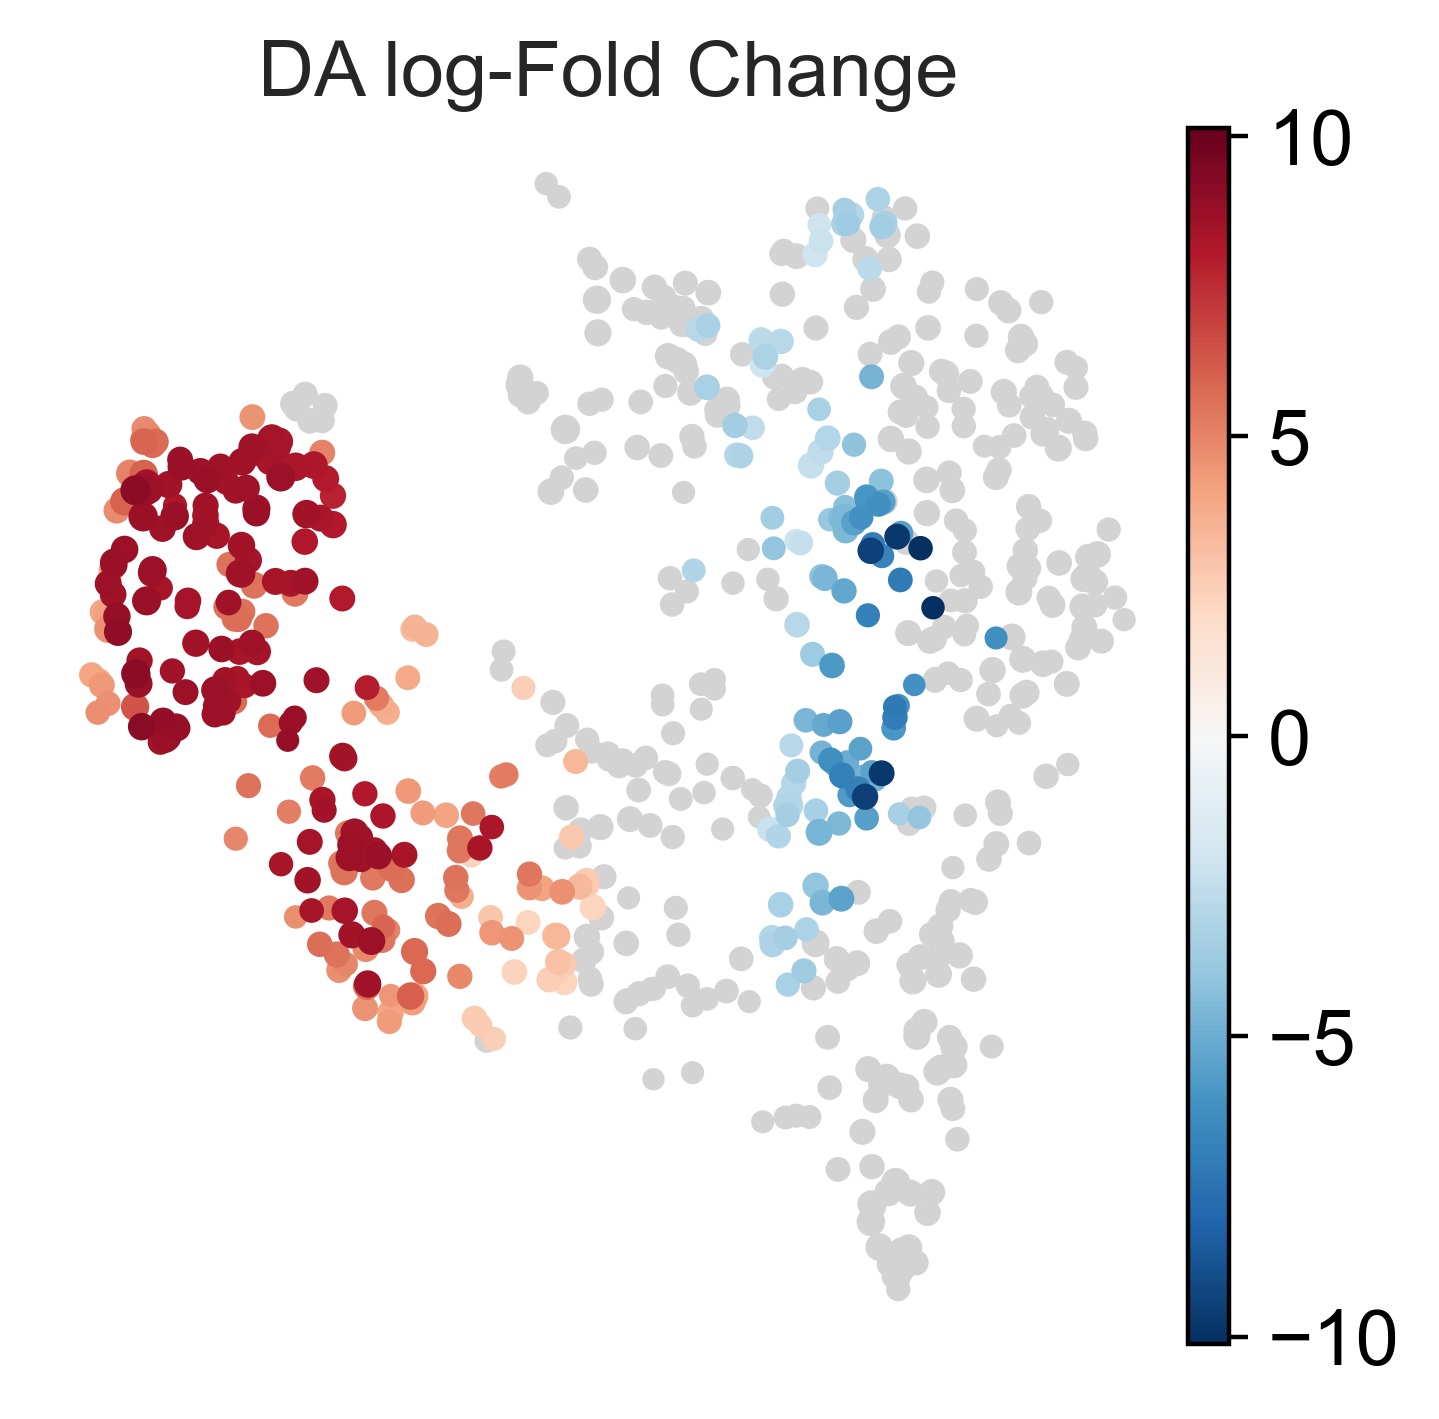

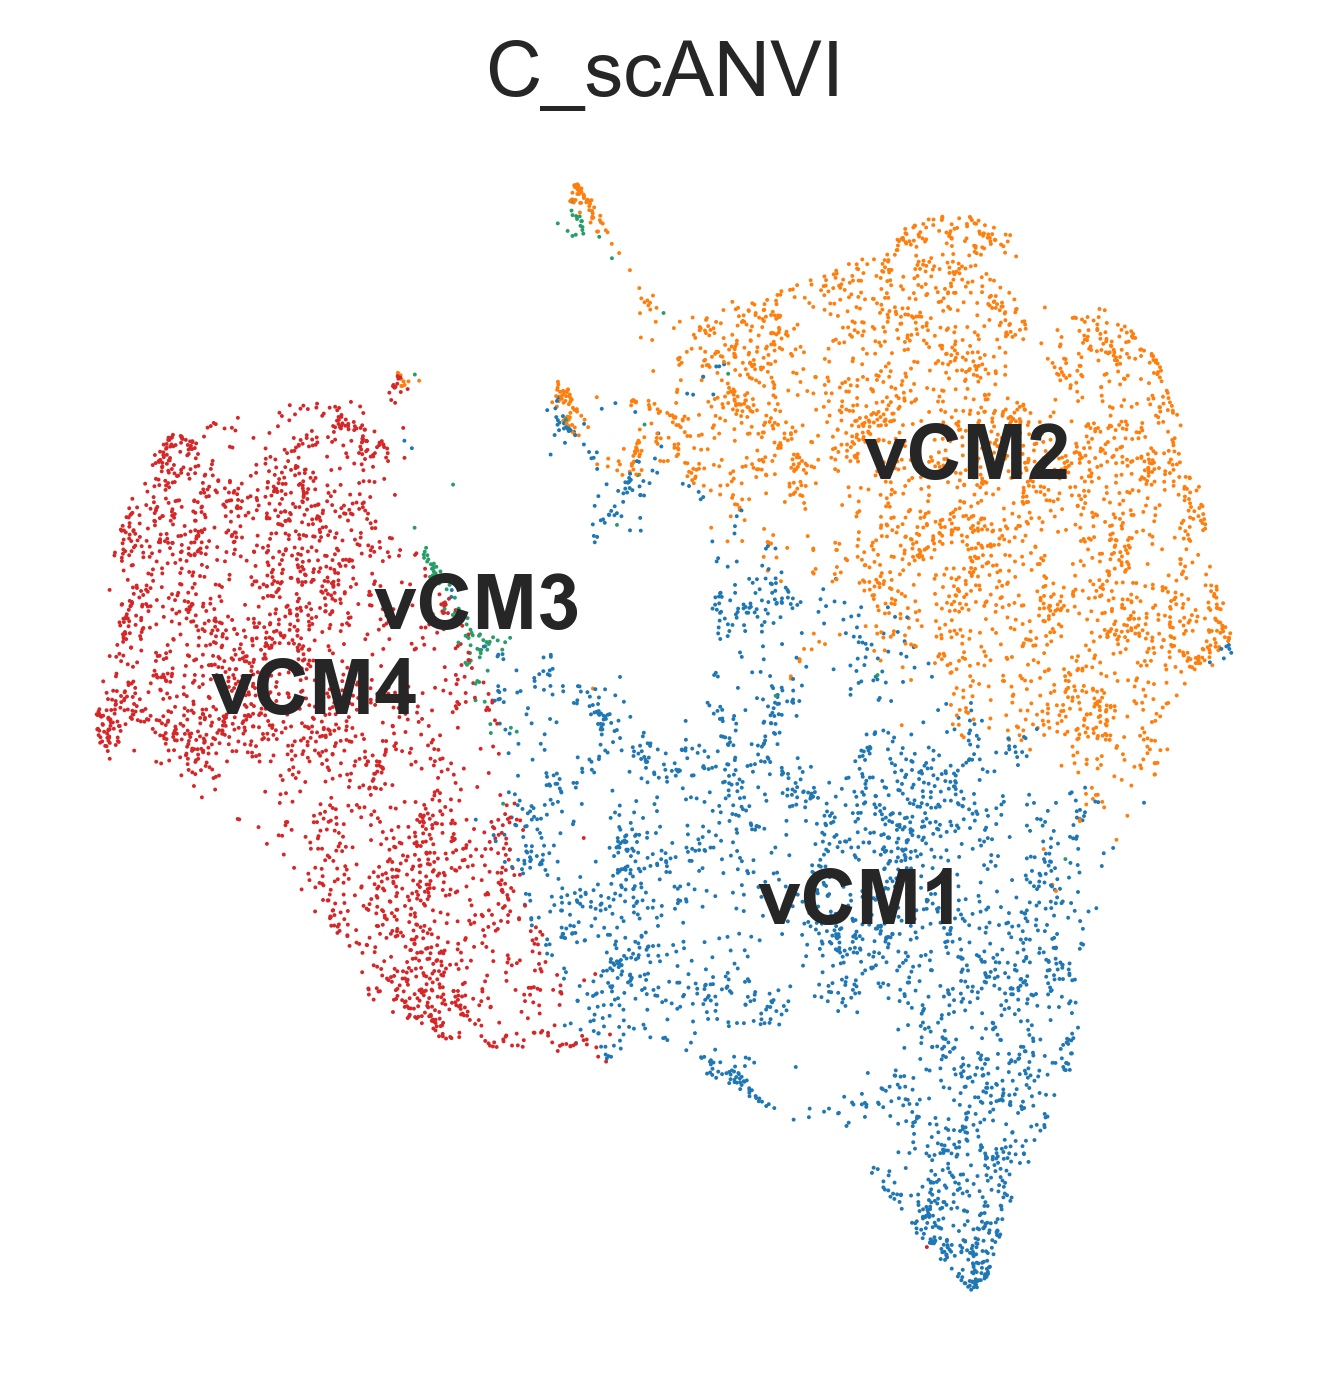

In [24]:
from pertpy.tools import Milo

milo = Milo()

with plt.rc_context({"figure.figsize": [4, 4]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.4, plot_edges=False)
    sc.pl.umap(mdata["rna"], color="C_scANVI", legend_loc="on data", frameon=False, size=2)

In [25]:

# Define as mixed if fraction of cells in nhood with same label is lower than 0.75
milo.annotate_nhoods(mdata, anno_col="C_scANVI")
#mdata["milo"].var = mdata["milo"].var.cat.add_categories(['Mixed'])
#mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.75, "nhood_annotation"] = "Mixed"

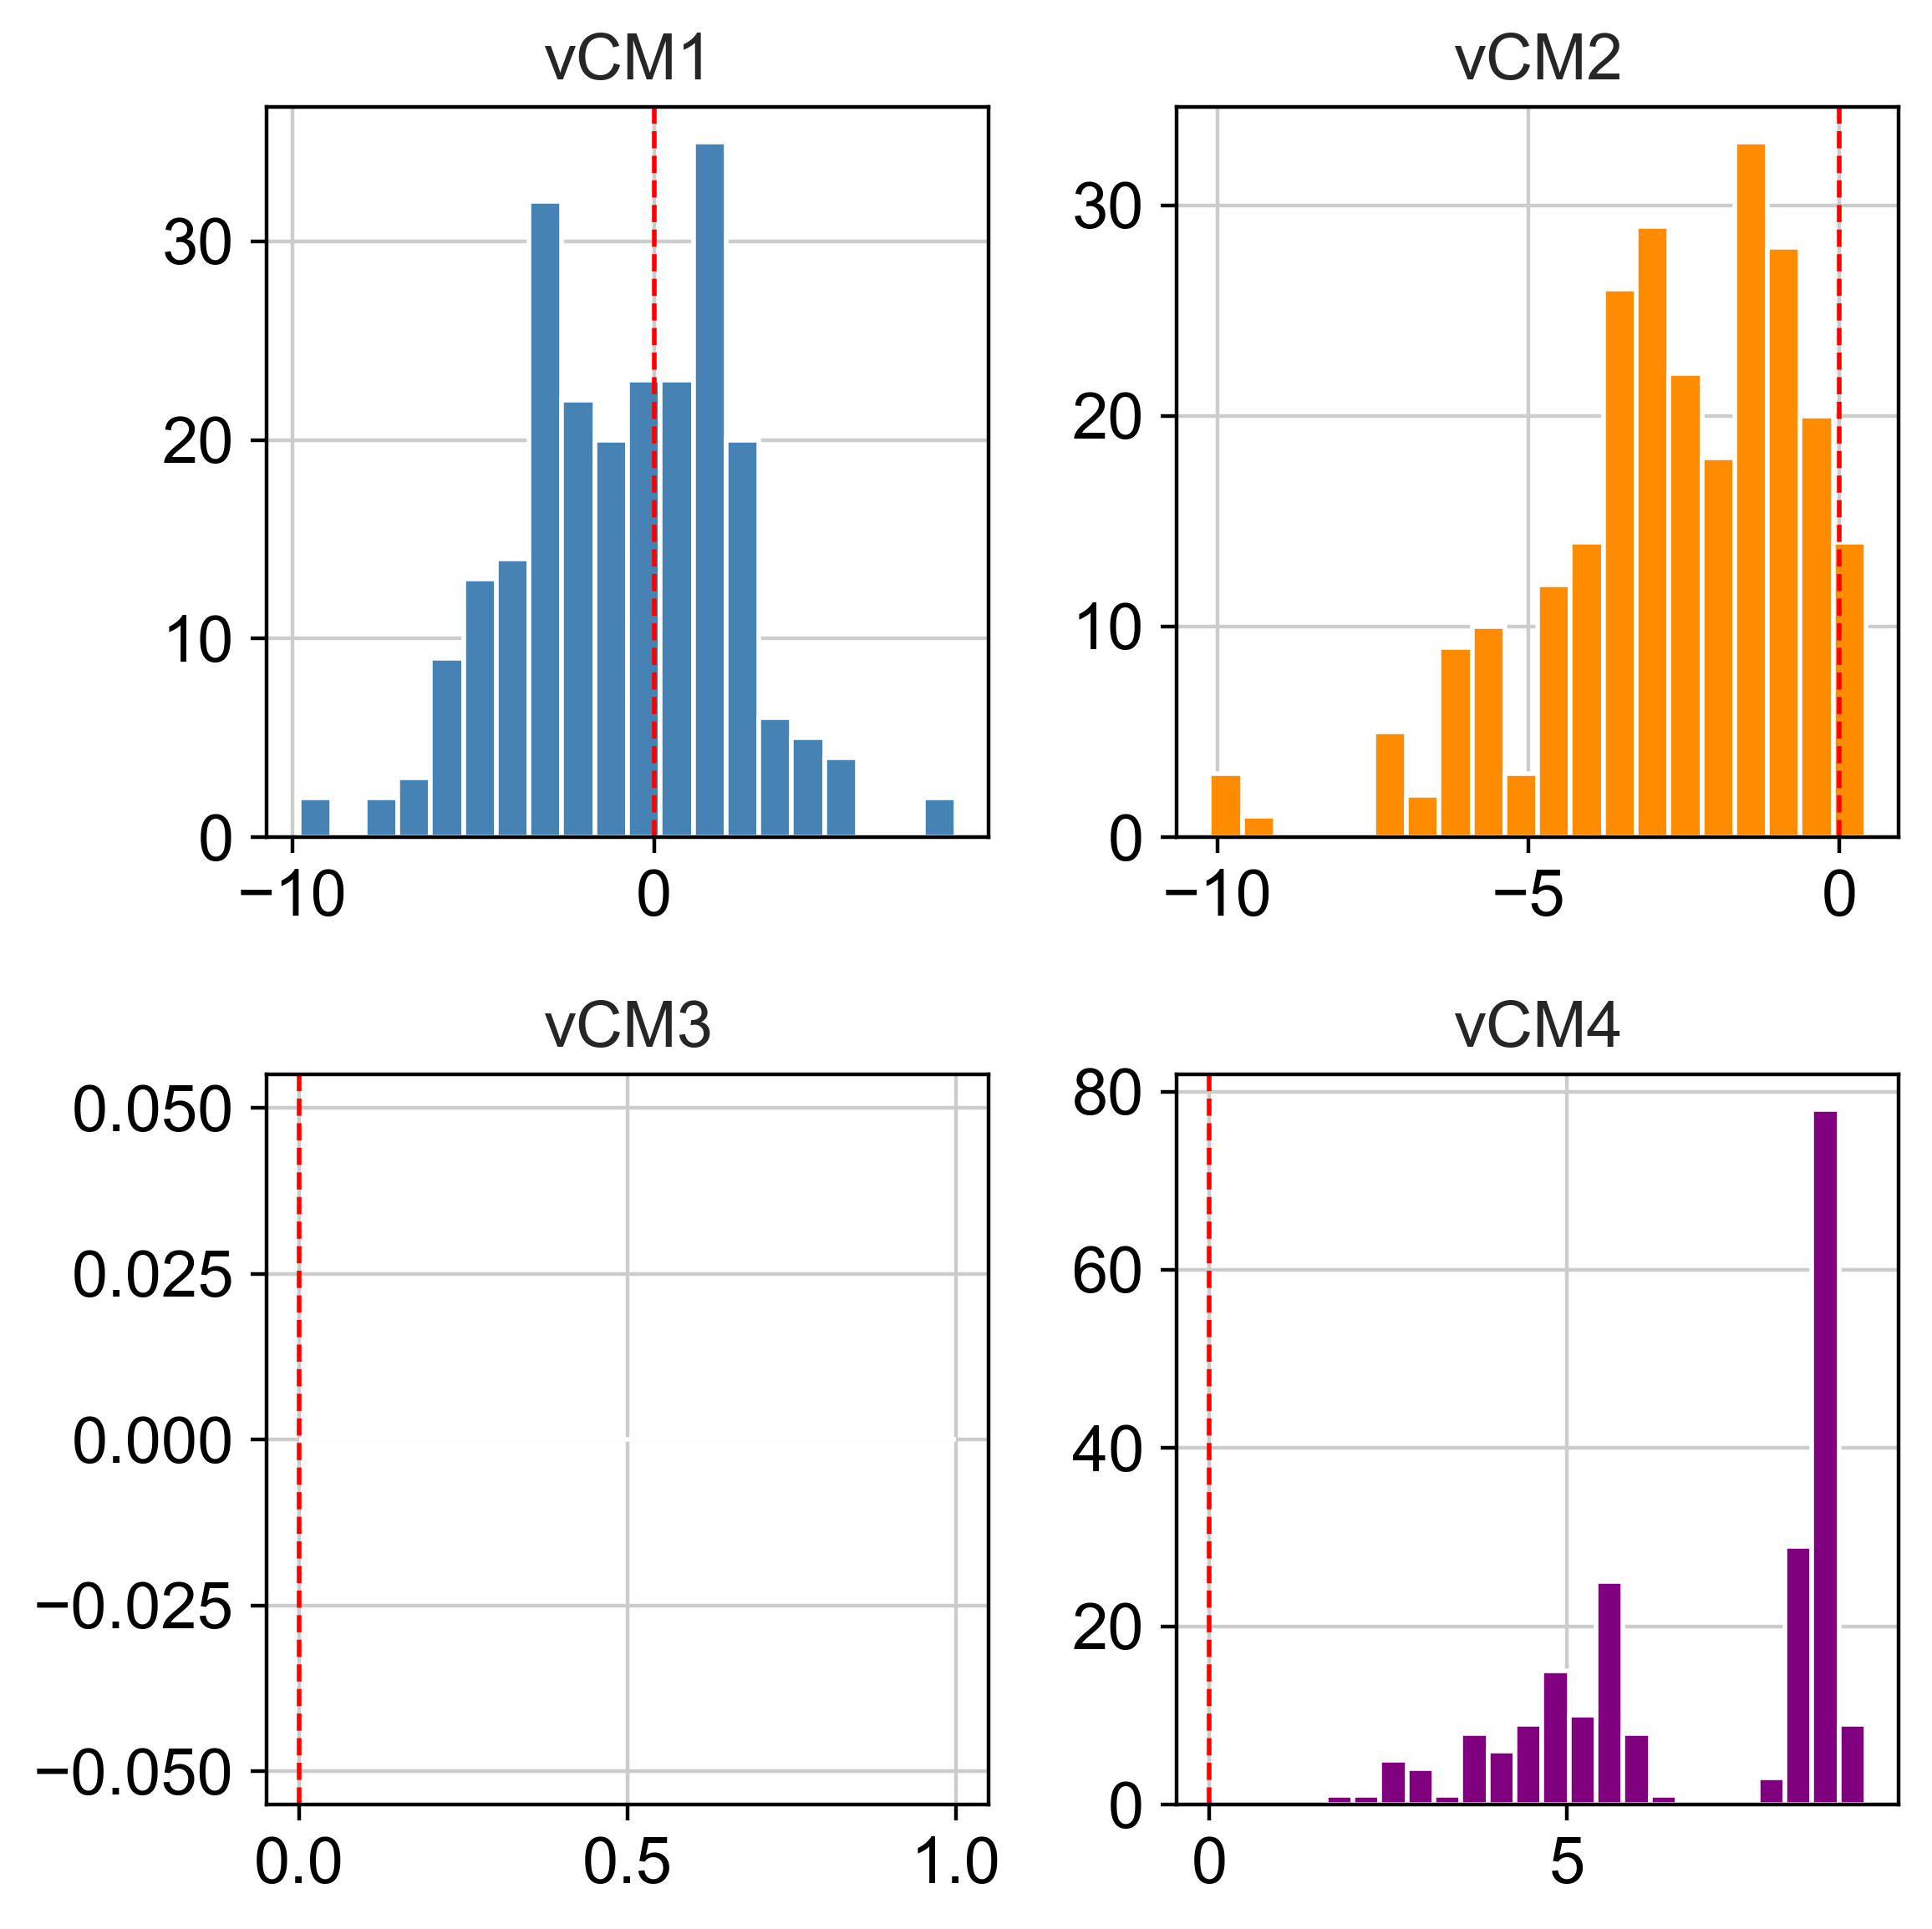

In [26]:
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, tight_layout=True, figsize=(6, 6))

# Plot vCM1 histogram
axs[0, 0].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["vCM1"])]["logFC"], bins=20, color="steelblue")
axs[0, 0].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[0, 0].set_title("vCM1")

# Plot vCM2 histogram
axs[0, 1].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["vCM2"])]["logFC"], bins=20, color="darkorange")
axs[0, 1].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[0, 1].set_title("vCM2")

# Plot vCM3 histogram
axs[1, 0].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["vCM3"])]["logFC"], bins=20, color="forestgreen")
axs[1, 0].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[1, 0].set_title("vCM3")

# Plot vCM4 histogram
axs[1, 1].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["vCM4"])]["logFC"], bins=20, color="purple")
axs[1, 1].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[1, 1].set_title("vCM4")

plt.tight_layout()

In [27]:
def significance_ratios(mdata_object):
    d = {"cell_compartments": [], "significance_ratio": []}
    for i in mdata_object["milo"].var["nhood_annotation"].unique():
        significant = 0
        insignificant = 0
        d["cell_compartments"].append(i)
        for j in mdata_object["milo"].var[mdata_object["milo"].var["nhood_annotation"].isin([i])]["Sig"]:
            if j == True:
                significant += 1
            else:
                insignificant += 1
        d["significance_ratio"].append(significant/(significant+insignificant))
    df = pd.DataFrame.from_dict(data=d)
    return df

In [28]:
mdata['rna'].obs.head()

cell_source cell_type donor      n_counts  n_genes  \
ACACTGATCATTATCC-1-A9_2  HIRI-Nuclei       NaN  A9_2  19942.757483     3851   
TCTTCCTGTCATAACC-1-A9_2  HIRI-Nuclei       NaN  A9_2  18663.787312     3577   
ATCTCTAGTTTCAGAC-1-A9_2  HIRI-Nuclei       NaN  A9_2  19071.693405     3632   
TGAATGCAGCTCCATA-1-A9_2  HIRI-Nuclei       NaN  A9_2  19333.201556     3691   
GCAGCTGCACAAGTGG-1-A9_2  HIRI-Nuclei       NaN  A9_2  19636.587384     3778   

                         percent_mito  percent_ribo region sample  \
ACACTGATCATTATCC-1-A9_2           NaN           NaN    NaN   A9_2   
TCTTCCTGTCATAACC-1-A9_2           NaN           NaN    NaN   A9_2   
ATCTCTAGTTTCAGAC-1-A9_2           NaN           NaN    NaN   A9_2   
TGAATGCAGCTCCATA-1-A9_2           NaN           NaN    NaN   A9_2   
GCAGCTGCACAAGTGG-1-A9_2           NaN           NaN    NaN   A9_2   

                         scrublet_score  ... XIST-counts   S_score G2M_score  \
ACACTGATCATTATCC-1-A9_2             NaN  ...         0.0 -0.218301 -0.450239   
TCTTCCTGTCATAACC-1-A9_2             NaN  ...         0.0  0.084806 -0.395886   
ATCTCTAGTTTCAGAC-1-A9_2             NaN  ...         0.0 -0.352962 -0.206640   
TGAATGCAGCTCCATA-1-A9_2             NaN  ...         1.0 -0.159373 -0.494394   
GCAGCTGCACAAGTGG-1-A9_2             NaN  ...         0.0  0.351369 -0.141495   

                        _scvi_batch  _scvi_labels  C_scANVI  cell_types  \
ACACTGATCATTATCC-1-A9_2           0             2      vCM2        vCM2   
TCTTCCTGTCATAACC-1-A9_2           0             2      vCM2        vCM2   
ATCTCTAGTTTCAGAC-1-A9_2           0             2      vCM2        vCM2   
TGAATGCAGCTCCATA-1-A9_2           0             2      vCM2        vCM2   
GCAGCTGCACAAGTGG-1-A9_2           0             2      vCM2        vCM2   

                         nhood_ixs_random  nhood_ixs_refined  \
ACACTGATCATTATCC-1-A9_2                 0                  0   
TCTTCCTGTCATAACC-1-A9_2                 1                  0   
ATCTCTAGTTTCAGAC-1-A9_2                 0                  0   
TGAATGCAGCTCCATA-1-A9_2                 1                  0   
GCAGCTGCACAAGTGG-1-A9_2                 1                  0   

                         nhood_kth_distance  
ACACTGATCATTATCC-1-A9_2                 0.0  
TCTTCCTGTCATAACC-1-A9_2                 0.0  
ATCTCTAGTTTCAGAC-1-A9_2                 0.0  
TGAATGCAGCTCCATA-1-A9_2                 0.0  
GCAGCTGCACAAGTGG-1-A9_2                 0.0  

[5 rows x 33 columns]

In [29]:
significance = significance_ratios(mdata)
significance

cell_compartments  significance_ratio
0              vCM2            0.244980
1              vCM1            0.336170
2              vCM4            0.967136

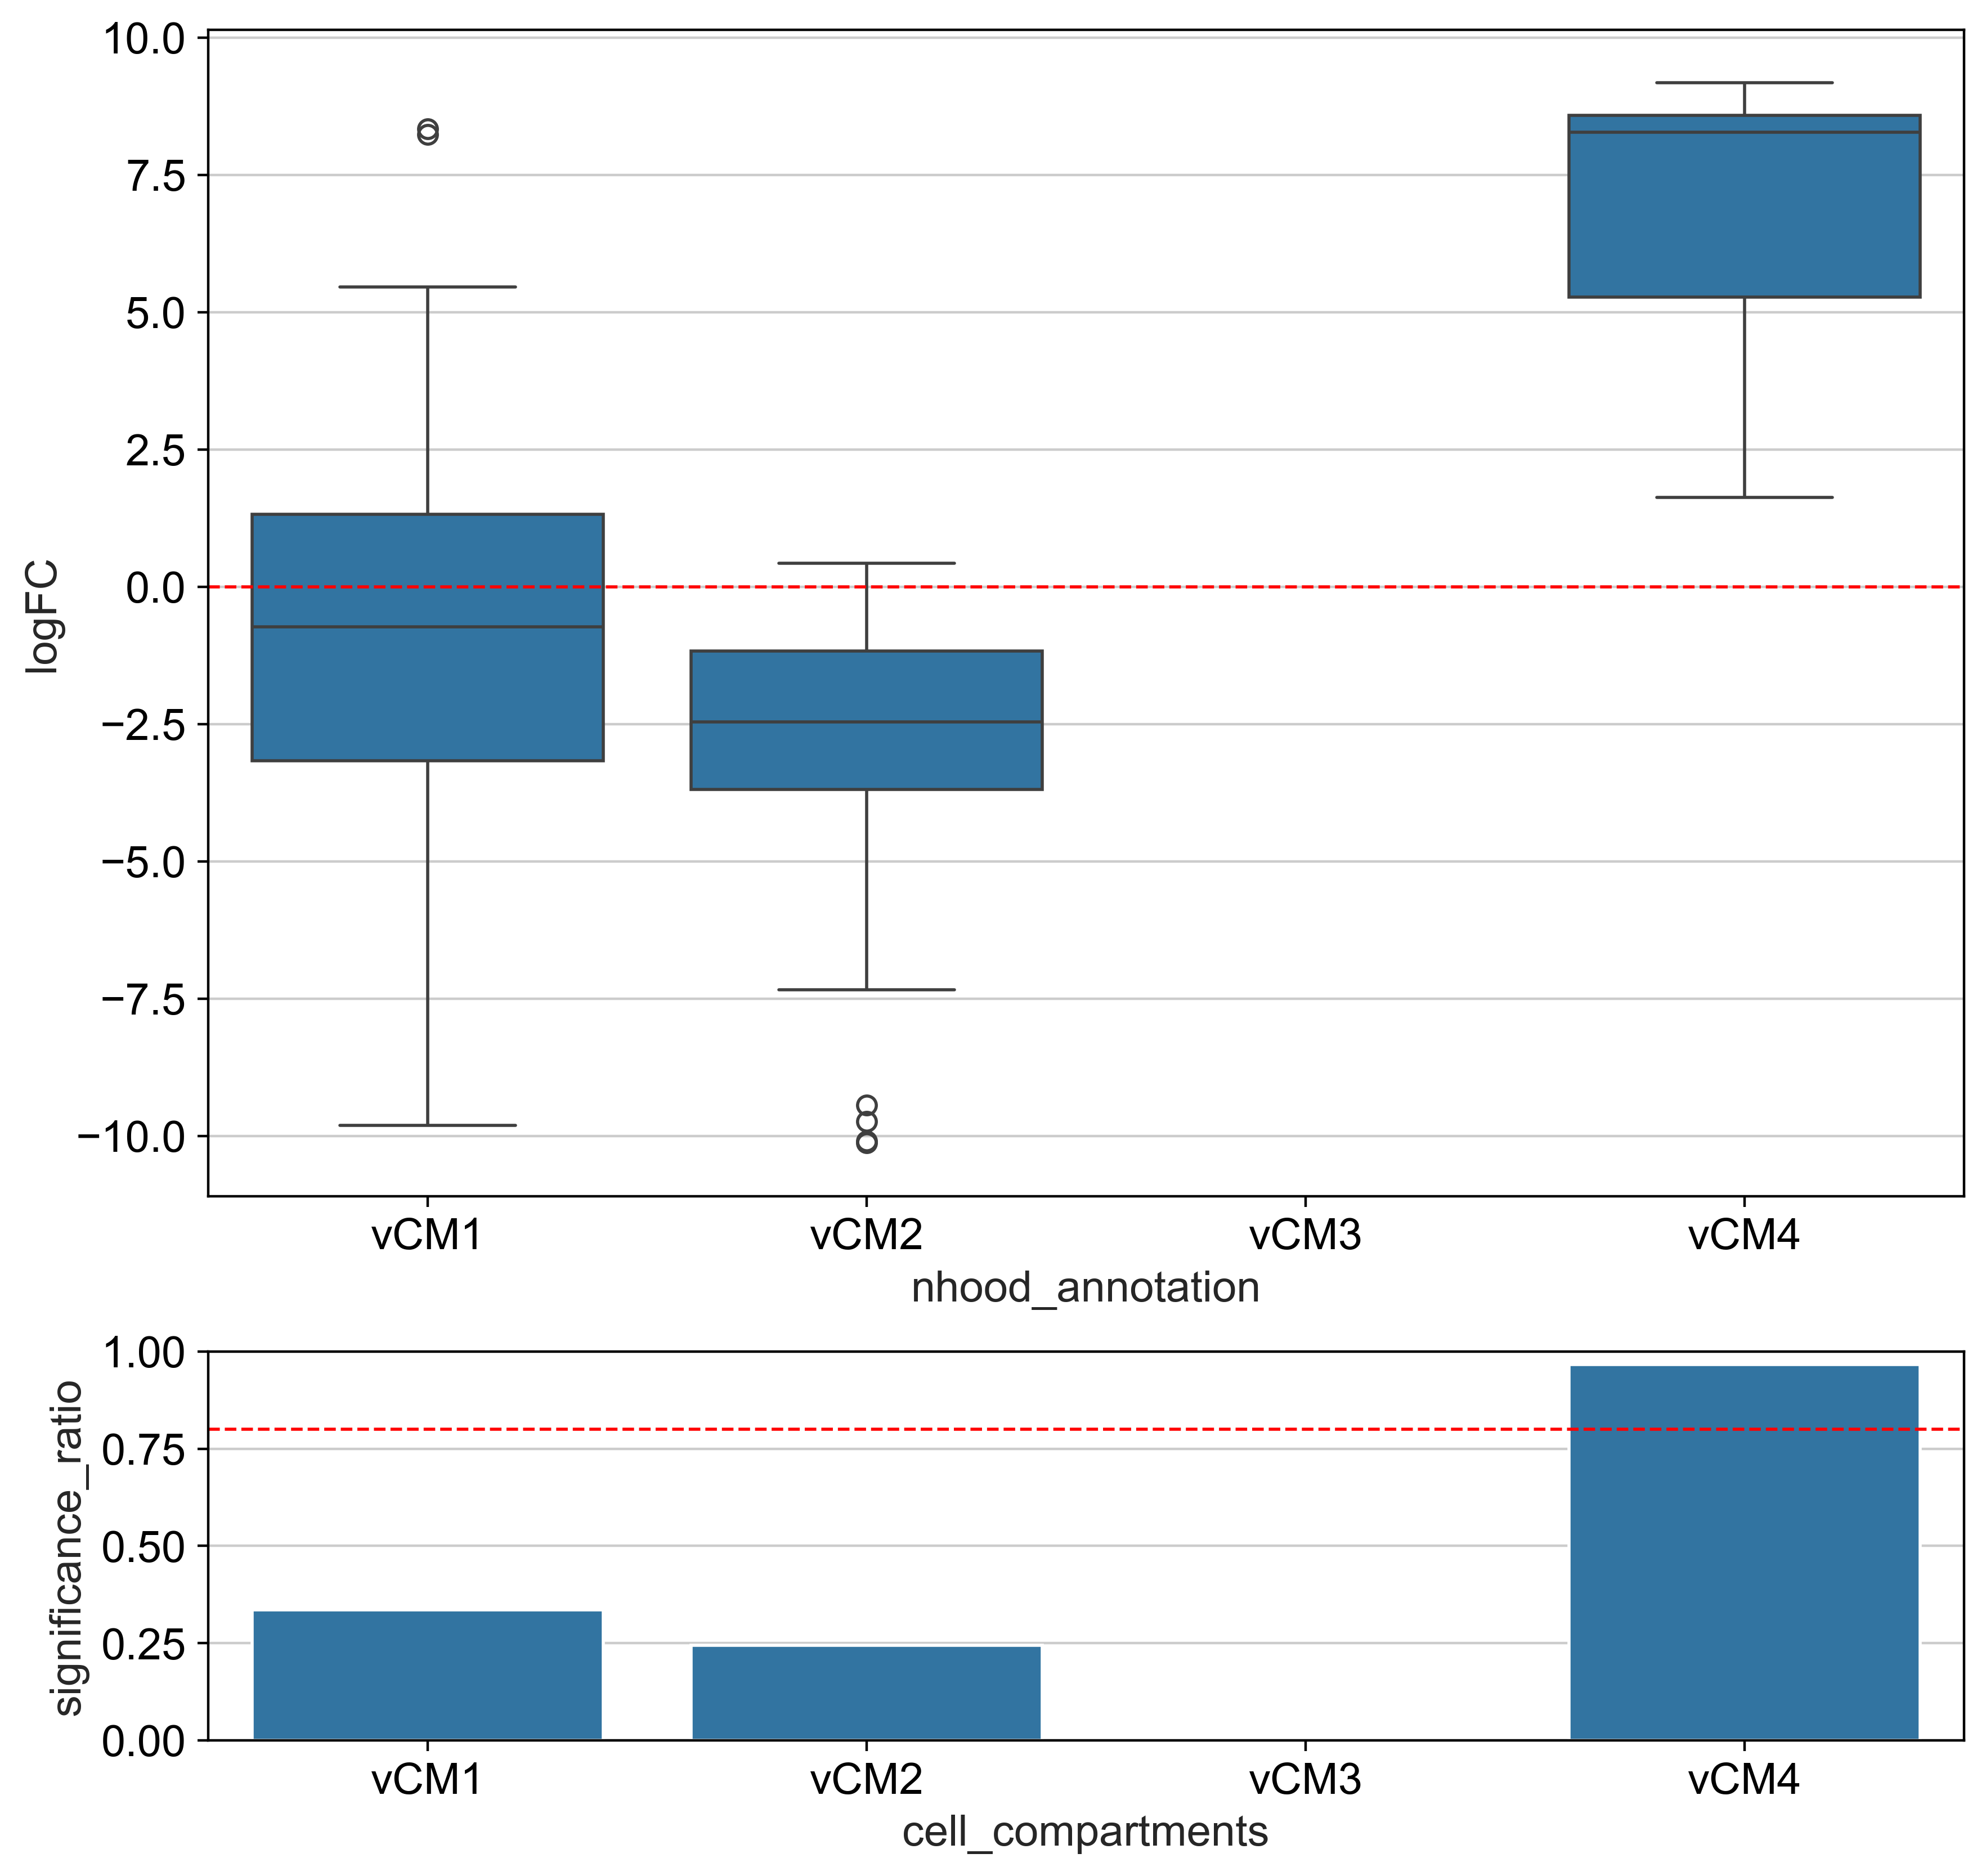

In [30]:
order = ["vCM1", "vCM2", "vCM3", "vCM4"]
fig, axs = plt.subplots(2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1]})
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=order, ax=axs[0])
axs[0].axhline(y=0, color='r', linewidth=1, linestyle='--')
sns.barplot(data=significance, x="cell_compartments", y="significance_ratio", order=order, ax=axs[1])
plt.ylim(0, 1)
axs[1].axhline(y=0.8, color='r', linewidth=1, linestyle='--')

<Axes: xlabel='nhood_annotation', ylabel='logFC'>

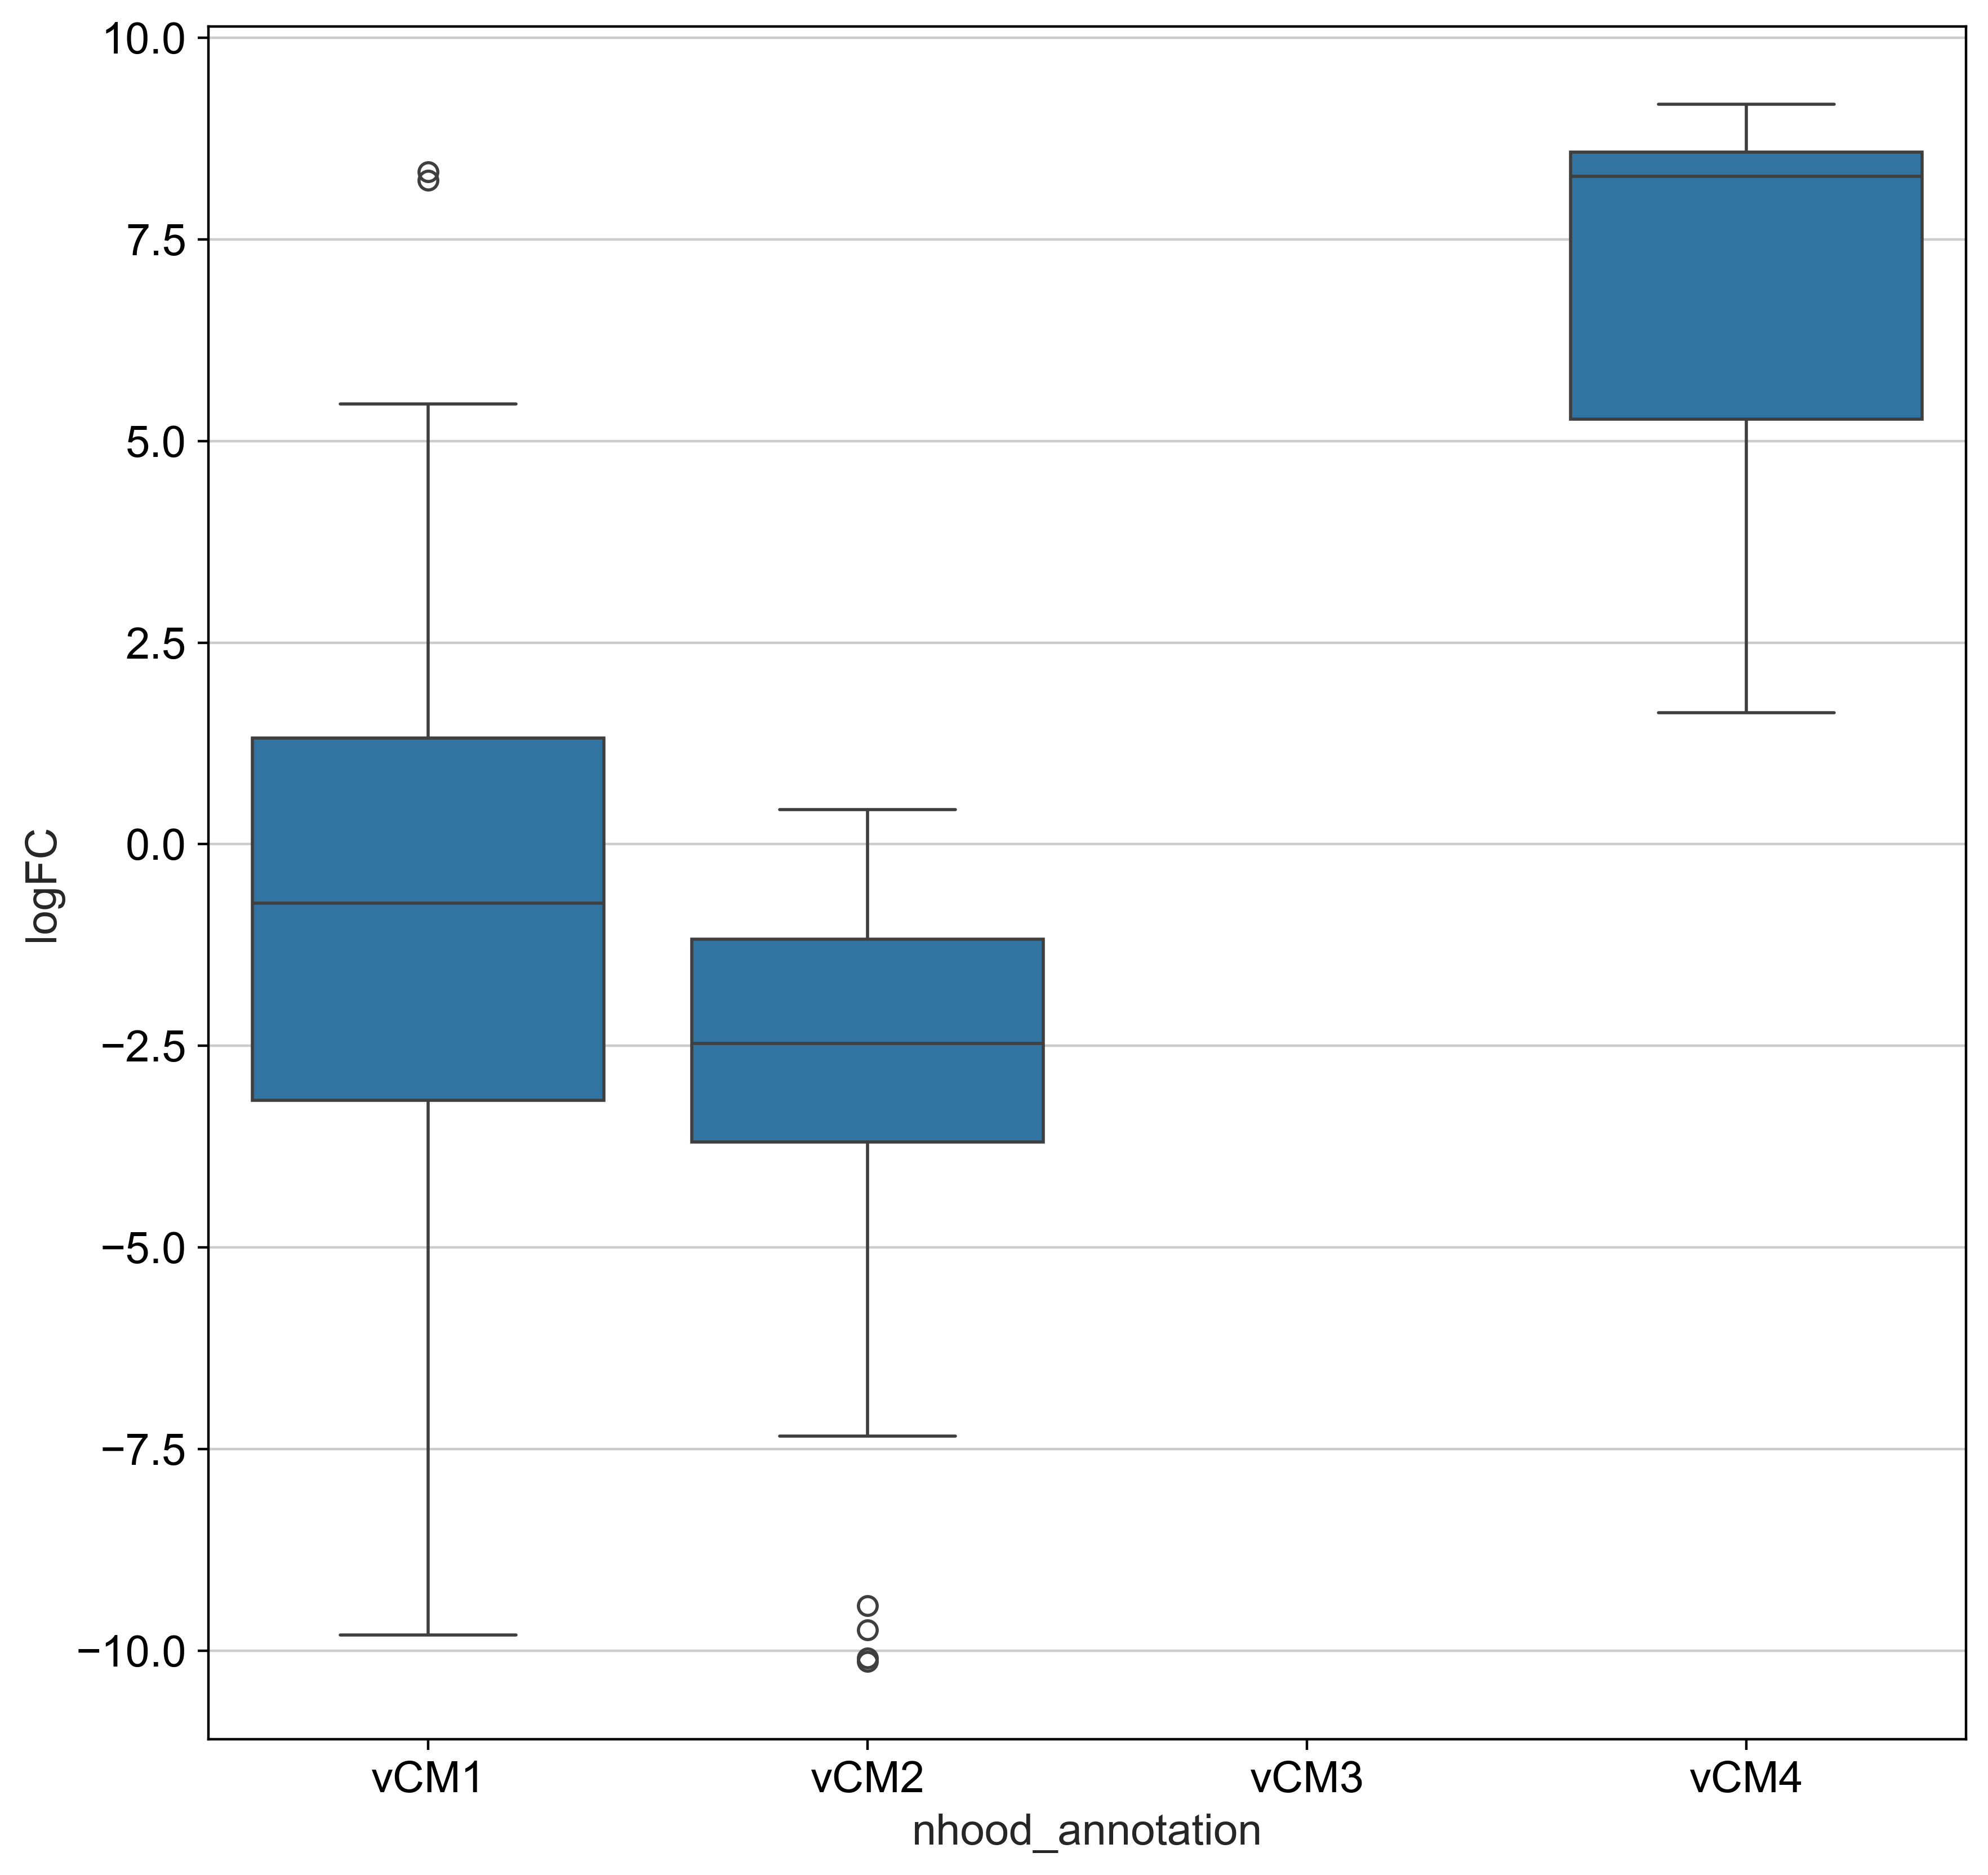

In [31]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC")

In [32]:
mdata["rna"]

AnnData object with n_obs × n_vars = 8257 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_types', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'neighbors', 'nhood_neighbors_key', 'milo', 'C_scANVI_colors', 'genotype_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap', 'nhoods'
    obsp: 'distances', 'connectivities', 'milo_distances', 'milo_connectivities'